<a href="https://colab.research.google.com/github/okayteakay/Exoplanets-Detection/blob/main/Exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [130]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,roc_curve,auc, f1_score, roc_auc_score,confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns
from sklearn.decomposition import PCA

## Load & PreProcess Data

In [131]:
train_data = pd.read_csv('exoTrain.csv')
test_data = pd.read_csv('exoTest.csv')
print(train_data)
print(test_data)

      LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
0         2    93.85    83.81  ...      61.42       5.08     -39.54
1         2   -38.88   -33.83  ...       6.46      16.00      19.93
2         2   532.64   535.92  ...     -28.91     -70.02     -96.67
3         2   326.52   347.39  ...     -17.31     -17.35      13.98
4         2 -1107.21 -1112.59  ...    -384.65    -411.79    -510.54
...     ...      ...      ...  ...        ...        ...        ...
3856      1   -11.24    -5.43  ...      -3.64      -6.35      -2.87
3857      1    10.40     4.90  ...      -2.27      -3.55      -5.13
3858      1    44.07    51.62  ...      -8.49     -19.86     -27.62
3859      1  -173.56  -171.09  ...      55.03     -24.97     -13.94
3860      1    99.12    76.85  ...        NaN        NaN        NaN

[3861 rows x 3198 columns]
     LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
0        2   119.88   100.21  ...      35.78     269.43      57.72
1        2  5736.59  5

In [132]:
train_data.dtypes

LABEL          int64
FLUX.1       float64
FLUX.2       float64
FLUX.3       float64
FLUX.4       float64
              ...   
FLUX.3193    float64
FLUX.3194    float64
FLUX.3195    float64
FLUX.3196    float64
FLUX.3197    float64
Length: 3198, dtype: object

In [133]:
train_data["LABEL"].replace({1: 0, 2: 1}, inplace=True)
print(train_data)

      LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
0         1    93.85    83.81  ...      61.42       5.08     -39.54
1         1   -38.88   -33.83  ...       6.46      16.00      19.93
2         1   532.64   535.92  ...     -28.91     -70.02     -96.67
3         1   326.52   347.39  ...     -17.31     -17.35      13.98
4         1 -1107.21 -1112.59  ...    -384.65    -411.79    -510.54
...     ...      ...      ...  ...        ...        ...        ...
3856      0   -11.24    -5.43  ...      -3.64      -6.35      -2.87
3857      0    10.40     4.90  ...      -2.27      -3.55      -5.13
3858      0    44.07    51.62  ...      -8.49     -19.86     -27.62
3859      0  -173.56  -171.09  ...      55.03     -24.97     -13.94
3860      0    99.12    76.85  ...        NaN        NaN        NaN

[3861 rows x 3198 columns]


In [134]:
test_data["LABEL"].replace({1: 0, 2: 1}, inplace=True)
print(test_data)


     LABEL   FLUX.1   FLUX.2  ...  FLUX.3195  FLUX.3196  FLUX.3197
0        1   119.88   100.21  ...      35.78     269.43      57.72
1        1  5736.59  5699.98  ...   -2366.19   -2294.86   -2034.72
2        1   844.48   817.49  ...    -162.68     -36.79      30.63
3        1  -826.00  -827.31  ...    -120.81    -257.56    -215.41
4        1   -39.57   -15.88  ...     -61.98     -69.34     -17.84
..     ...      ...      ...  ...        ...        ...        ...
565      0   374.46   326.06  ...    -213.63    -205.99    -194.07
566      0    -0.36     4.96  ...      -5.32     -10.98     -11.24
567      0   -54.01   -44.13  ...       5.47      14.46      18.70
568      0    91.36    85.60  ...      -8.43      -6.48      17.60
569      0  3071.19  2782.53  ...    -277.22     -69.63     121.56

[570 rows x 3198 columns]


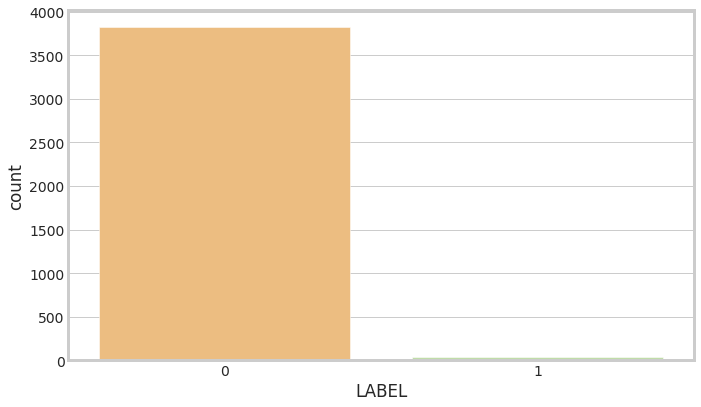

In [135]:
sns.set_style('whitegrid')
sns.countplot(x='LABEL',data=train_data,palette='Spectral')
plt.show()

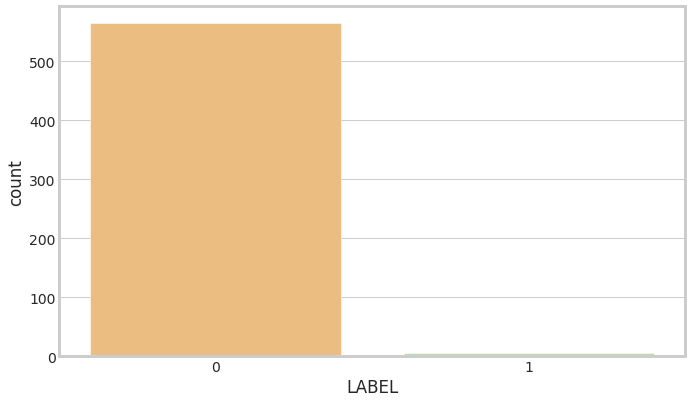

In [136]:
sns.set_style('whitegrid')
sns.countplot(x='LABEL',data=test_data,palette='Spectral')
plt.show()

### Optimising to reduce memory usage

In [137]:
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    dftest_data = reduce_memory(test_data)
    return (dftest_data)
    

### Observing intensity of fluxes

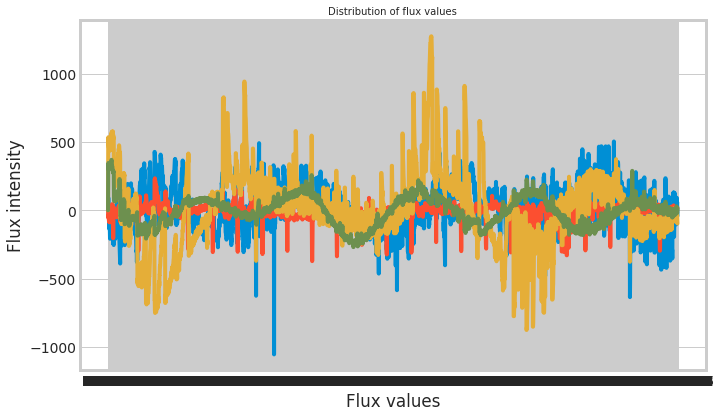

In [138]:
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

In [139]:
print(train_data.iloc[0,])

LABEL         1.00
FLUX.1       93.85
FLUX.2       83.81
FLUX.3       20.10
FLUX.4      -26.98
             ...  
FLUX.3193    92.54
FLUX.3194    39.32
FLUX.3195    61.42
FLUX.3196     5.08
FLUX.3197   -39.54
Name: 0, Length: 3198, dtype: float64


#### Guassian Histogram

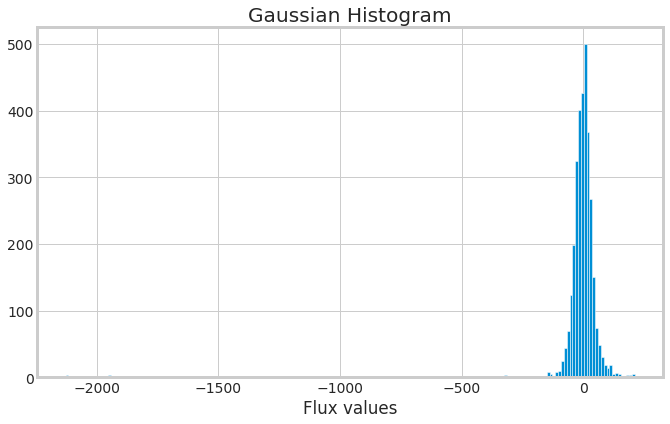

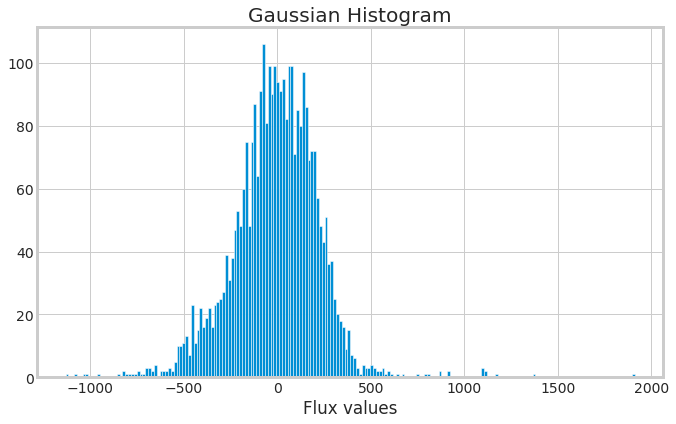

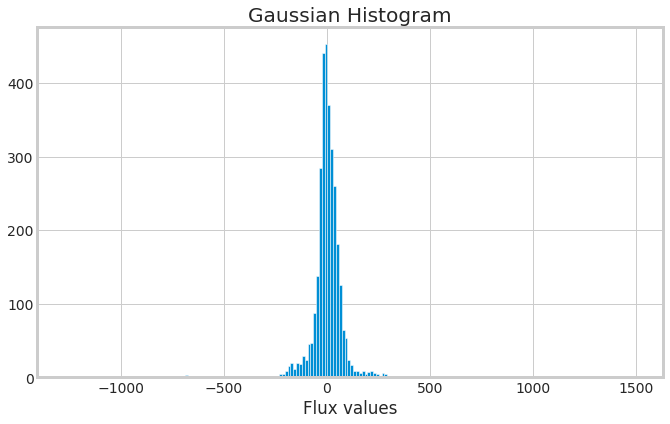

In [140]:
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

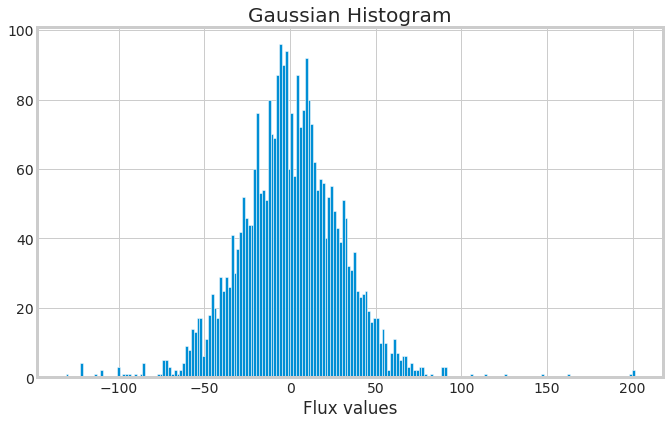

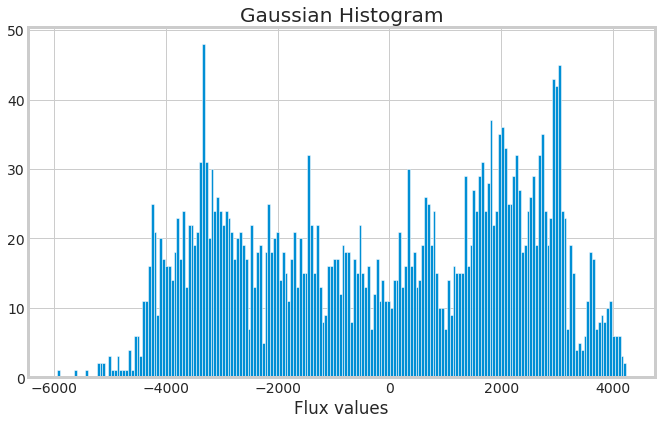

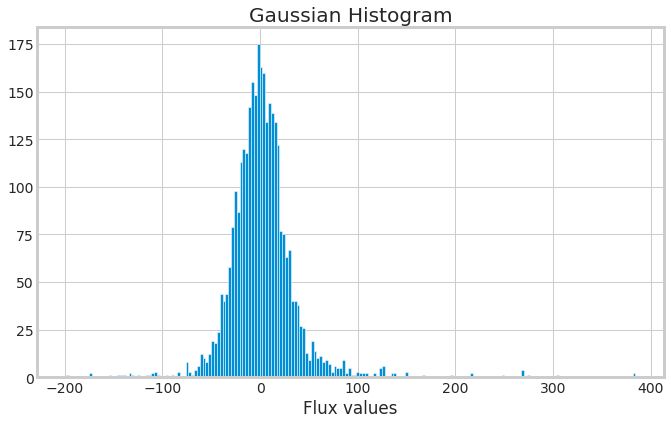

In [141]:
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

#### Filling NA Values

In [142]:
train_data.isna().sum()

LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    1
FLUX.3194    1
FLUX.3195    1
FLUX.3196    1
FLUX.3197    1
Length: 3198, dtype: int64

In [143]:

count = np.isinf(train_data).values.sum() 
print("It contains " + str(count) + " infinite values") 

It contains 0 infinite values


In [144]:
list = []
for i,cols in enumerate(train_data.columns):
  me = np.mean(train_data[cols])
  train_data[cols] = train_data.fillna(me)
  # print(f'{i} out of {len(train_data.columns)} done') 

In [145]:
train_data.isna().sum()

LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    0
FLUX.3194    0
FLUX.3195    0
FLUX.3196    0
FLUX.3197    0
Length: 3198, dtype: int64

#### Normalizing and Splitting

In [146]:
X_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
X_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

In [147]:
X_train = normalize(X_train)

In [148]:
X_test = normalize(X_test)

In [149]:
X_train = ndimage.filters.gaussian_filter(X_train, sigma=10)
X_test = ndimage.filters.gaussian_filter(X_test, sigma=10)


In [150]:
std_scaler = StandardScaler()
X_train = scaled = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

In [151]:
np.mean(X_train),np.std(X_train)

(-2.2139227649275425e-15, 0.9999999999998939)

In [152]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3861, 3197)
y_train: (3861,)
X_test: (570, 3197)
y_test: (570,)


## Logistic Regression Model

In [153]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 5)
classifier.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [154]:
y_pred = classifier.predict(X_test)


In [155]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred1)
print(cm)
accuracy_score(y_test,y_pred)

[[565   0]
 [  5   0]]


0.9912280701754386